# Introduction

This kernel is going to solve House Pricing with Advanced Regression Analysis, a machine learning dataset from Kaggle. It includes four steps: downloading data and creting validation datasets, EDA, data cleaning, fitting and validating linear regression models.


In [1]:
# Printing every output instead of just last one
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# importing the packages
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import arrow
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [3]:
# Figures inline and set visualization style
%matplotlib inline
sns.set()
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

---

## Downloading the Data, Creating Training and Validation data sets.

Data is downloaded from Kaggle. The data in train.csv is data that has values on the target variable. The data in test.csv is for generating predictions. 

“Hold out” cross-validation is used with a random split of the data into 80% training, 20% validation. The random number generator seed is set to a value, so that it would be possible to recreate the split if needed.

### Importing Data

Reading the data from the two csv files I downloaded from Kaggle.com.

In [4]:
# Checking that the data files in the present working directory for this Notebook
os.listdir()

['.DS_Store',
 'test.csv',
 'MSDS422 | Assignment 1 | Katya Nosulko.ipynb',
 'data_description.txt',
 'Assignment-1 Katya Nosulko.ipynb',
 'sync-1-msds-422-58-winter-2022-v1.ipynb',
 'train.csv',
 '.ipynb_checkpoints',
 'sample_submission.csv']

In [5]:
trainDat = pd.read_csv('train.csv')
testDat =  pd.read_csv('test.csv')

In [6]:
#checking the data
trainDat.shape
testDat.shape

(1460, 81)

(1459, 80)

In [7]:
# Checking that SalePrice is not in the test data (the variabble that we need to predict)
set(trainDat.columns).difference(set(testDat.columns))

{'SalePrice'}

In [8]:
# Checking that the features in the test data a subset of the train data features
set(testDat.columns).issubset(set(trainDat.columns))

True

### Spliting the Data for Hold Out Cross Validation

Doing a random 80/20 split of the trainDat data.  The train split will be for model training.  The test split will be for model validation.

In [9]:
yDat = trainDat.SalePrice      # Our "Y" variable

XDat = trainDat.loc[:,trainDat.columns!='SalePrice']  # Potential X's

In [10]:
# Random split using a scikit-learn preprocessing method
# seting the seed for the random generator so the results that we get can be reproduced
# shuffling the data before splitting

Xtrain, Xtest, ytrain, ytest = train_test_split( XDat, yDat, \
        train_size=0.8, random_state=9,                      \
         shuffle=True )

#checking the results
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1168, 80), (292, 80), (1168,), (292,))

Xtrain and ytrain are to be used for model training.  xtest and ytest are to be used to validate the models, to find out how well they generalize to data they haven't "learned" from.


---

## EDA

- Using descriptive statistics and graphs to understand the distributions of the target variable and the features (all the other variables that might predict the target) in the training data, the random 80% data set you created. 
- Documenting the data types (categorical, ordered continuous, et.c) of the target and features. 
- Examining the target and features for problems like missing and incorrect (or suspicious) values, or that have limited or no variation.

In [11]:
# Data types of the potential features
Xtrain.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

In [12]:
# Data type of the target
ytrain.dtype

dtype('int64')

In [13]:
# taking a look at the train data
Xtrain.head()
ytrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1392,1393,85,RL,68.0,7838,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnWw,NaN,0,12,2006,WD,Normal
426,427,80,RL,NaN,12800,Pave,NaN,Reg,Low,AllPub,...,396,0,NaN,NaN,NaN,0,8,2009,WD,Normal
321,322,60,RL,99.0,12099,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
425,426,60,RM,60.0,3378,Pave,Grvl,Reg,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
102,103,90,RL,64.0,7018,Pave,NaN,Reg,Bnk,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Alloca


1392    123000
426     275000
321     354000
425     135000
102     118964
Name: SalePrice, dtype: int64

In [14]:
#checking the data types, missing values
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 1392 to 382
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    960 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          77 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  Overal

In [15]:
# summarizing the data
Xtrain.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,1168.000000,960.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1161.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,731.872432,57.020548,70.161458,10259.947774,6.066781,5.587329,1970.083904,1984.011986,104.846684,439.532534,...,469.875856,91.159247,46.315068,22.773973,2.898116,16.046233,2.893836,48.830479,6.310788,2007.836473
std,422.892705,42.433793,24.603254,7184.387102,1.382592,1.118165,30.292742,20.785101,178.606890,461.118816,...,215.108241,122.201957,67.849259,62.066970,26.321831,57.489908,40.736249,548.916607,2.680691,1.336254
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,366.750000,20.000000,60.000000,7559.500000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,...,317.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,70.000000,9485.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,379.500000,...,477.500000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1099.250000,70.000000,80.000000,11604.000000,7.000000,6.000000,2000.000000,2003.000000,171.000000,697.250000,...,576.000000,165.250000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


**The average sale price of a house is approx 180k, with most of the values falling within the 129k to 212k range.**

In [16]:
Xtrain.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1168,1168,77,1168,1168,1168,1168,1168,1168,1168,...,1100,1100,1100,1100,1168,6,231,46,1168,1168
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,924,1165,41,753,1040,1167,842,1101,197,1012,...,689,495,1043,1055,1067,3,124,41,1015,955


### Checking for missing values

<AxesSubplot:>

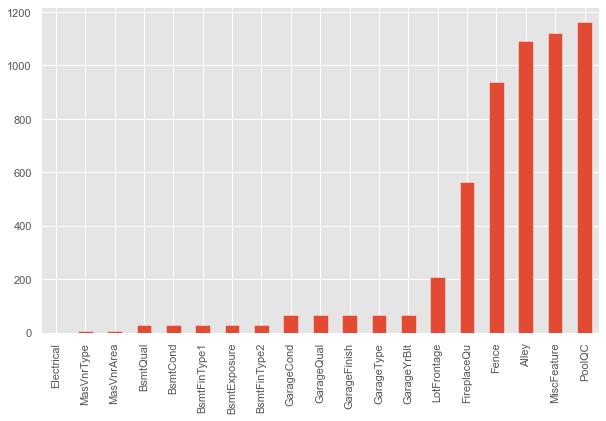

In [17]:
missing_data = Xtrain.isnull().sum()
missing_data = missing_data[missing_data>0]
missing_data.sort_values(inplace=True)
missing_data.plot.bar()

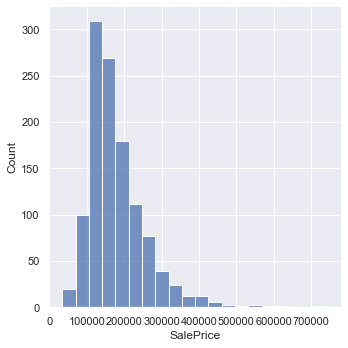

In [18]:
sns.set(rc={'figure.figsize':(15,8)})
sns.displot(ytrain, bins=20);

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

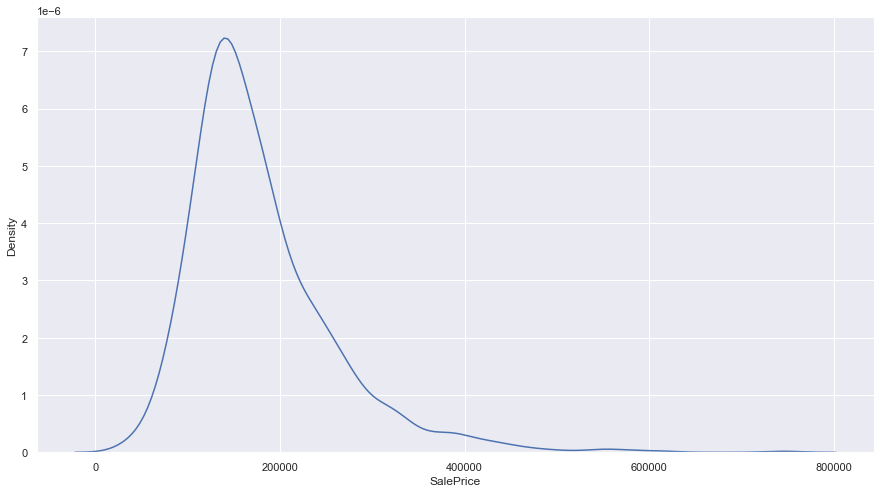

In [19]:
sns.kdeplot(ytrain)

In [20]:
ytrain.describe()

count      1168.000000
mean     178753.636986
std       78296.025999
min       34900.000000
25%      129000.000000
50%      159697.500000
75%      212000.000000
max      745000.000000
Name: SalePrice, dtype: float64

### Looking for correlations

In [21]:
mergedxy=Xtrain.join(ytrain)

In [22]:
#selecting numeric features
numeric = mergedxy.select_dtypes(include=[np.number])
numeric.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [23]:
#selecting categorical features
categorical = mergedxy.select_dtypes(include=[object])
categorical.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [24]:
#looking for correlations
correlations = mergedxy.corr()
print(correlations['SalePrice'].sort_values(ascending=False),'\n')

SalePrice        1.000000
OverallQual      0.789335
GrLivArea        0.699250
GarageCars       0.637448
GarageArea       0.628478
TotalBsmtSF      0.606144
1stFlrSF         0.602790
FullBath         0.566347
YearBuilt        0.548451
TotRmsAbvGrd     0.544250
YearRemodAdd     0.517346
GarageYrBlt      0.496660
MasVnrArea       0.460624
Fireplaces       0.451156
BsmtFinSF1       0.376794
LotFrontage      0.334471
OpenPorchSF      0.314776
2ndFlrSF         0.309395
WoodDeckSF       0.300691
HalfBath         0.285252
LotArea          0.281523
BsmtUnfSF        0.225554
BsmtFullBath     0.215414
BedroomAbvGr     0.172962
ScreenPorch      0.118925
PoolArea         0.117562
3SsnPorch        0.066073
MoSold           0.058249
BsmtFinSF2      -0.012538
MiscVal         -0.017251
BsmtHalfBath    -0.017628
Id              -0.020511
YrSold          -0.028802
LowQualFinSF    -0.052486
MSSubClass      -0.078036
OverallCond     -0.082409
EnclosedPorch   -0.132450
KitchenAbvGr    -0.138324
Name: SalePr

#### Only the first 10 (after the SalePrice) variables have a correlation of above 0.5, so we will only use them to create a heatmap.

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'TotRmsAbvGrd',
       'YearRemodAdd'],
      dtype='object')


<AxesSubplot:>

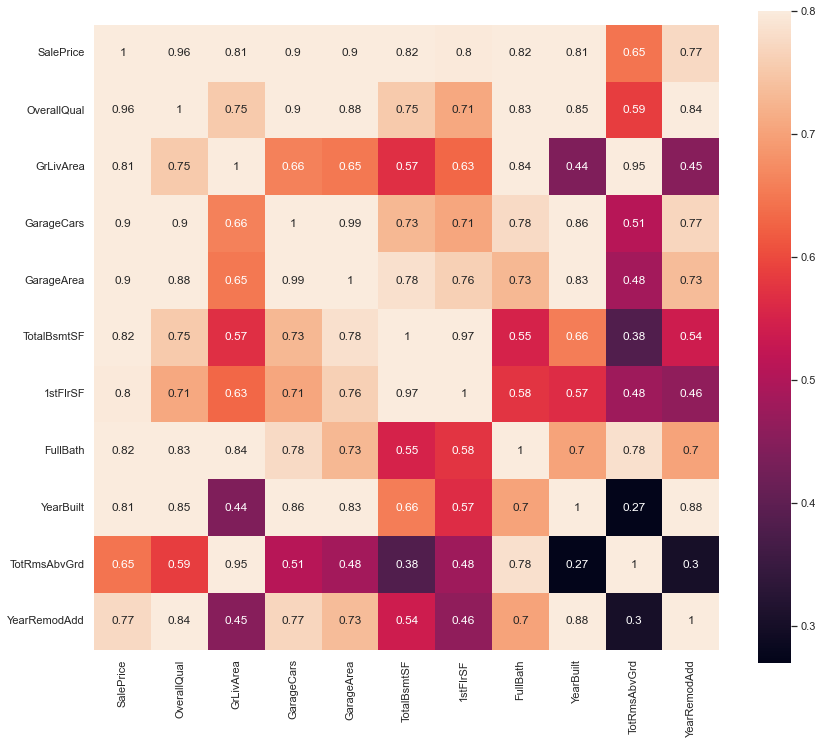

In [25]:
#creating a heatmap
k=11
cols = correlations.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(correlations[cols].values.T)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(cm, square=True, vmax=0.8,annot=True, xticklabels=cols.values,yticklabels=cols.values)

#### Adding scatterplots for the variables that showed most correlation with the SalePrice

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

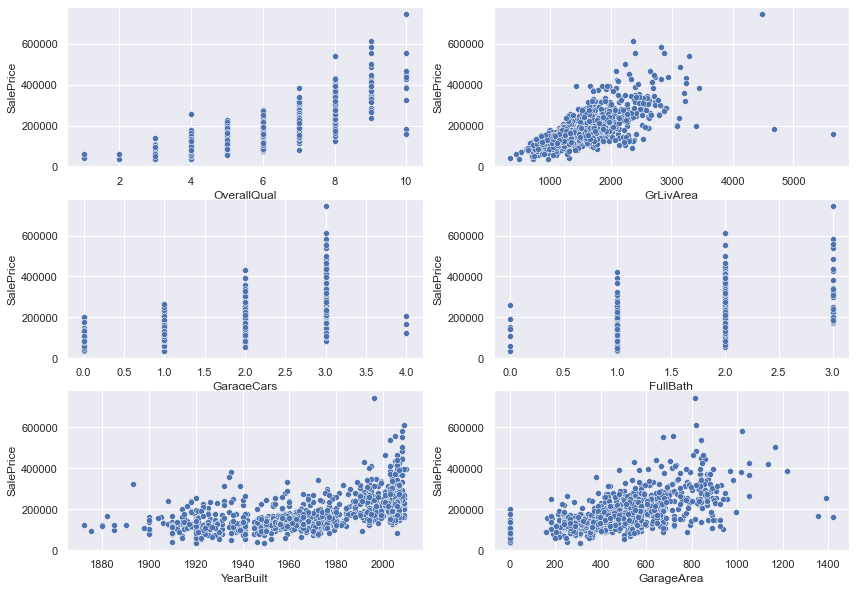

In [26]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(14,10))
sns.scatterplot(x='OverallQual',y='SalePrice', data = mergedxy, ax=ax1)
sns.scatterplot(x='GrLivArea',y='SalePrice', data = mergedxy, ax=ax2)
sns.scatterplot(x='GarageCars',y='SalePrice', data = mergedxy, ax=ax3)
sns.scatterplot(x='FullBath',y='SalePrice', data = mergedxy, ax=ax4)
sns.scatterplot(x='YearBuilt',y='SalePrice', data = mergedxy, ax=ax5)
sns.scatterplot(x='GarageArea',y='SalePrice', data = mergedxy, ax=ax6)

### Adding boxplots to find outliers

In [27]:
mergedxy['SalePrice'].describe()

count      1168.000000
mean     178753.636986
std       78296.025999
min       34900.000000
25%      129000.000000
50%      159697.500000
75%      212000.000000
max      745000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice'>

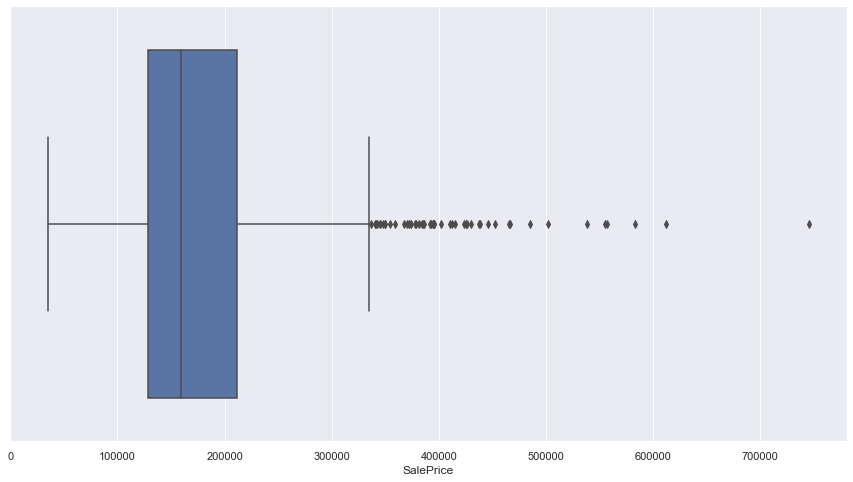

In [28]:
sns.boxplot(x=mergedxy['SalePrice'])

In [29]:
mergedxy.shape

(1168, 81)

In [30]:
first_q = mergedxy['SalePrice'].quantile(0.25)
third_q = mergedxy['SalePrice'].quantile(0.75)
IQR = third_q - first_q

In [31]:
new_boundary = third_q + 3*IQR

In [32]:
mergedxy.drop(mergedxy[mergedxy['SalePrice']>new_boundary].index, axis= 0, inplace = True)

In [33]:
mergedxy.shape

(1158, 81)

<AxesSubplot:xlabel='SalePrice'>

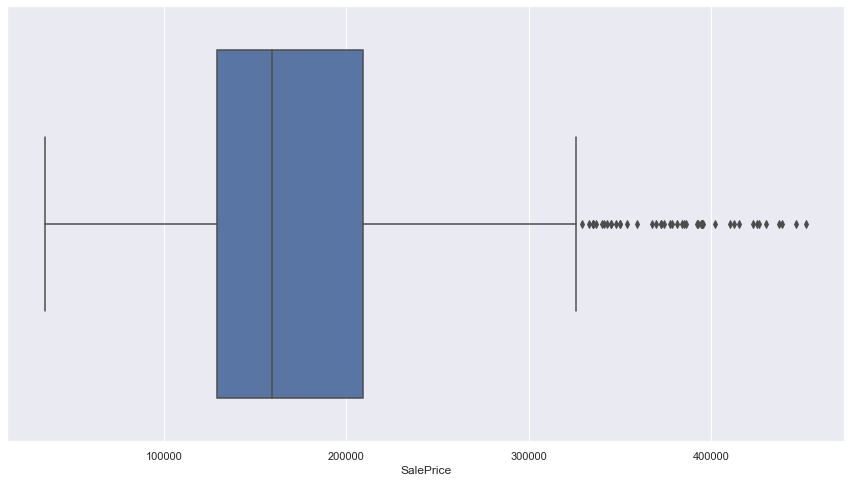

In [34]:
#checking the results
sns.boxplot(x=mergedxy['SalePrice'])

(-0.5, 8.5, 0.0, 800000.0)

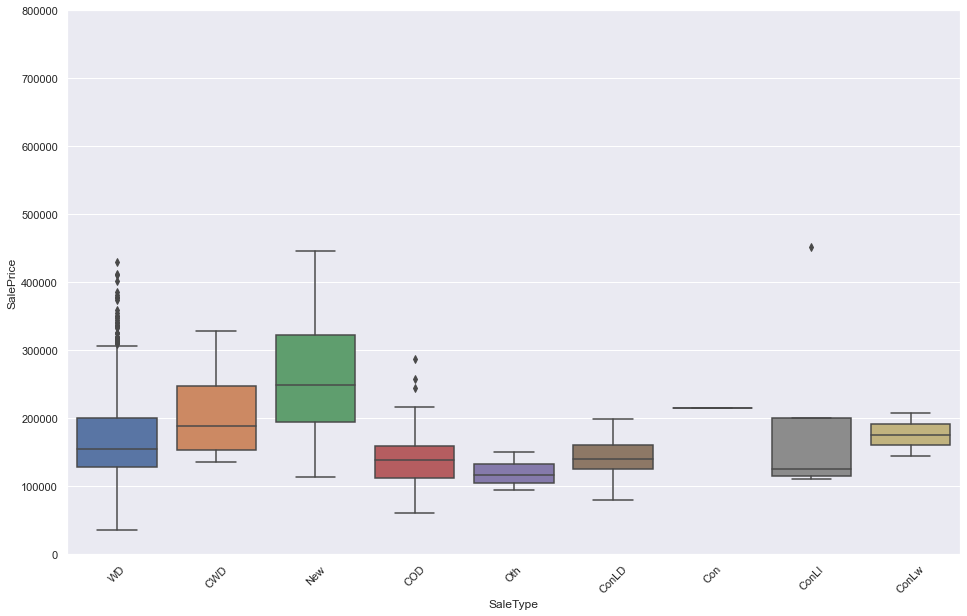

In [35]:
f,ax = plt.subplots(figsize=(16,10))
fig=sns.boxplot(x='SaleType', y='SalePrice', data=mergedxy)
fig.axis(ymin=0,ymax=800000)
xt=plt.xticks(rotation=45)

(-0.5, 9.5, 0.0, 800000.0)

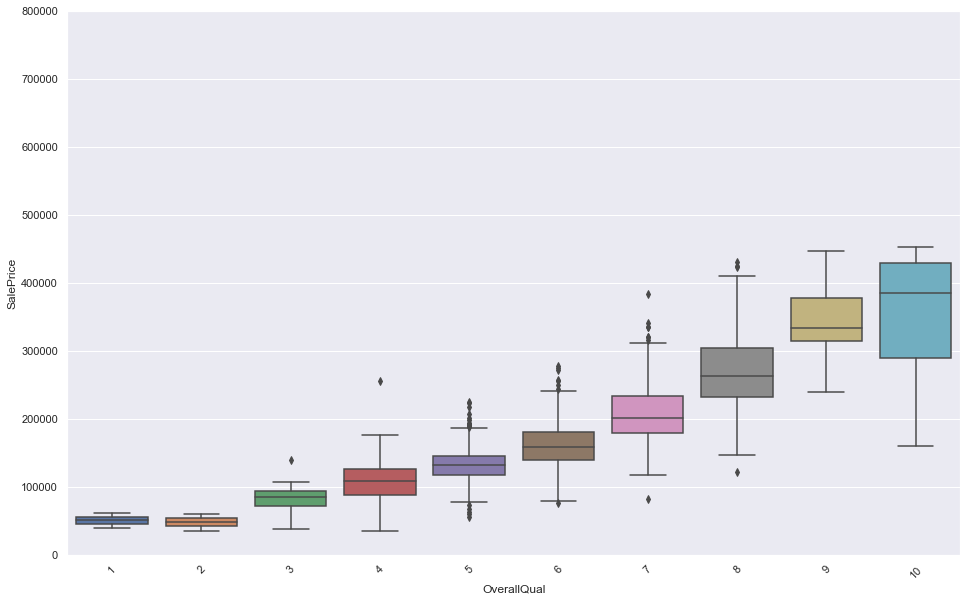

In [36]:
f,ax = plt.subplots(figsize=(16,10))
fig=sns.boxplot(x='OverallQual', y='SalePrice', data=mergedxy)
fig.axis(ymin=0,ymax=800000)
xt=plt.xticks(rotation=45)

---

## Cleaning, Transformations, and Rescaling

### Removing some variables for a variety of reasons:
**Multicollinear features**
1. GarageArea (GarageCars)  
2. TotalBsmtSF (1stFlrSF)  
3. TotRmsAbvGrd (GrLivArea)  
<br>
**Variables that are missing more than 20% of values:**
<br>
4. FireplaceQu  
5. Fence  
6. Alley  
7. MiscFeature  
8. PoolQC  
<br>
**Features with poor correlation with SalePrice:**
<br>
9. GarageYrBlt      
10. MasVnrArea       
11. Fireplaces     
12. BsmtFinSF1
13. LotFrontage     
14. OpenPorchSF   
15. 2ndFlrSF   
16. WoodDeckSF 
17. HalfBath    
18. LotArea  
19. BsmtUnfSF  
20. BsmtFullBath  
21. BedroomAbvGr  
22. ScreenPorch  
23. PoolArea  
24. 3SsnPorch  
25. MoSold   
26. BsmtFinSF2  
27. MiscVal  
28. BsmtHalfBath  
29. Id  
30. YrSold  
31. LowQualFinSF  
32. MSSubClass  
33. OverallCond  
34. EnclosedPorch  
35. KitchenAbvGr  

In [37]:
#droping the rows in the training set
mergedxy.drop(['GarageArea','TotalBsmtSF','TotRmsAbvGrd','FireplaceQu', 
            'Fence', 'Alley', 'MiscFeature', 
            'PoolQC','GarageYrBlt','MasVnrArea','Fireplaces',
            'BsmtFinSF1','LotFrontage','OpenPorchSF',
            '2ndFlrSF','WoodDeckSF','HalfBath','LotArea',
            'BsmtUnfSF','BsmtFullBath','BedroomAbvGr','ScreenPorch',
            'PoolArea','3SsnPorch','MoSold','BsmtFinSF2','MiscVal',
            'BsmtHalfBath','Id','YrSold','LowQualFinSF','MSSubClass',
            'OverallCond','EnclosedPorch','KitchenAbvGr'],axis=1,inplace=True)

In [38]:
#checking the data for null values
with pd.option_context('display.max_rows', None,):
   print(mergedxy.isnull().sum())

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        6
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         30
BsmtCond         30
BsmtExposure     31
BsmtFinType1     30
BsmtFinType2     31
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
1stFlrSF          0
GrLivArea         0
FullBath          0
KitchenQual       0
Functional        0
GarageType       68
GarageFinish     68
GarageCars        0
GarageQual       68
GarageCond       68
PavedDrive        0
SaleType          0
SaleCondition     0
SalePrice         0
dtype: int64


In [39]:
#handling the null values (all are non numerical)
mergedxy['MasVnrType']=mergedxy['MasVnrType'].fillna(mergedxy['MasVnrType'].mode()[0])
mergedxy['BsmtQual']=mergedxy['BsmtQual'].fillna(mergedxy['BsmtQual'].mode()[0])
mergedxy['BsmtCond']=mergedxy['BsmtCond'].fillna(mergedxy['BsmtCond'].mode()[0])
mergedxy['BsmtExposure']=mergedxy['BsmtExposure'].fillna(mergedxy['BsmtExposure'].mode()[0])
mergedxy['BsmtFinType1']=mergedxy['BsmtFinType1'].fillna(mergedxy['BsmtFinType1'].mode()[0])
mergedxy['BsmtFinType2']=mergedxy['BsmtFinType2'].fillna(mergedxy['BsmtFinType2'].mode()[0])
mergedxy['Electrical']=mergedxy['Electrical'].fillna(mergedxy['Electrical'].mode()[0])
mergedxy['GarageType']=mergedxy['GarageType'].fillna(mergedxy['GarageType'].mode()[0])
mergedxy['GarageFinish']=mergedxy['GarageFinish'].fillna(mergedxy['GarageFinish'].mode()[0])
mergedxy['GarageQual']=mergedxy['GarageQual'].fillna(mergedxy['GarageQual'].mode()[0])
mergedxy['GarageCond']=mergedxy['GarageCond'].fillna(mergedxy['GarageCond'].mode()[0])

In [40]:
#confirming there are no null values anymore
mergedxy.isnull().sum().sum()

0

In [41]:
mergedxy.shape

(1158, 46)

In [43]:
dummy=pd.get_dummies(mergedxy['ExterCond'])

In [44]:
mergedxy=mergedxy.merge(dummy,left_index=True,right_index=True)

In [45]:
mergedxy.shape

(1158, 51)

### Doing same cleaning process on test data

In [46]:
Xtest.shape

(292, 80)

In [47]:
#droping same rows in xtest data
Xtest.drop(['GarageArea','TotalBsmtSF','TotRmsAbvGrd','FireplaceQu', 
            'Fence', 'Alley', 'MiscFeature', 
            'PoolQC','GarageYrBlt','MasVnrArea','Fireplaces',
            'BsmtFinSF1','LotFrontage','OpenPorchSF',
            '2ndFlrSF','WoodDeckSF','HalfBath','LotArea',
            'BsmtUnfSF','BsmtFullBath','BedroomAbvGr','ScreenPorch',
            'PoolArea','3SsnPorch','MoSold','BsmtFinSF2','MiscVal',
            'BsmtHalfBath','Id','YrSold','LowQualFinSF','MSSubClass',
            'OverallCond','EnclosedPorch','KitchenAbvGr'],axis=1,inplace=True)

/Users/katya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [48]:
Xtest.shape

(292, 45)

In [51]:
dummy1=pd.get_dummies(Xtest['ExterCond'])

In [52]:
Xtest=Xtest.merge(dummy1,left_index=True,right_index=True)

In [53]:
Xtest['Po'] = 0

In [54]:
Xtest.shape

(292, 50)

In [55]:
testDat.shape

(1459, 80)

In [56]:
#droping same rows in test data
testDat.drop(['GarageArea','TotalBsmtSF','TotRmsAbvGrd','FireplaceQu', 
              'Fence', 'Alley', 'MiscFeature', 
              'PoolQC','GarageYrBlt','MasVnrArea','Fireplaces',
              'BsmtFinSF1','LotFrontage','OpenPorchSF',
              '2ndFlrSF','WoodDeckSF','HalfBath','LotArea',
              'BsmtUnfSF','BsmtFullBath','BedroomAbvGr','ScreenPorch',
              'PoolArea','3SsnPorch','MoSold','BsmtFinSF2','MiscVal',
              'BsmtHalfBath','Id','YrSold','LowQualFinSF','MSSubClass',
              'OverallCond','EnclosedPorch','KitchenAbvGr'],axis=1,inplace=True)

In [57]:
testDat.shape

(1459, 45)

In [59]:
dummy2=pd.get_dummies(testDat['ExterCond'])

In [60]:
testDat=testDat.merge(dummy2,left_index=True,right_index=True)

In [61]:
testDat.shape

(1459, 50)

In [62]:
Xtest = Xtest[testDat.columns]

In [63]:
#checking for null values in xtest dataset
with pd.option_context('display.max_rows', None,):
   print(Xtest.isnull().sum())

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        1
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual          7
BsmtCond          7
BsmtExposure      7
BsmtFinType1      7
BsmtFinType2      7
Heating           0
HeatingQC         0
CentralAir        0
Electrical        0
1stFlrSF          0
GrLivArea         0
FullBath          0
KitchenQual       0
Functional        0
GarageType       13
GarageFinish     13
GarageCars        0
GarageQual       13
GarageCond       13
PavedDrive        0
SaleType          0
SaleCondition     0
Ex                0
Fa                0
Gd                0
Po                0
TA                0


In [64]:
#handling null values in xtest dataset
Xtest['MasVnrType']=Xtest['MasVnrType'].fillna(Xtest['MasVnrType'].mode()[0])
Xtest['BsmtQual']=Xtest['BsmtQual'].fillna(Xtest['BsmtQual'].mode()[0])
Xtest['BsmtCond']=Xtest['BsmtCond'].fillna(Xtest['BsmtCond'].mode()[0])
Xtest['BsmtExposure']=Xtest['BsmtExposure'].fillna(Xtest['BsmtExposure'].mode()[0])
Xtest['BsmtFinType1']=Xtest['BsmtFinType1'].fillna(Xtest['BsmtFinType1'].mode()[0])
Xtest['BsmtFinType2']=Xtest['BsmtFinType2'].fillna(Xtest['BsmtFinType2'].mode()[0])
Xtest['Electrical']=Xtest['Electrical'].fillna(Xtest['Electrical'].mode()[0])
Xtest['GarageType']=Xtest['GarageType'].fillna(Xtest['GarageType'].mode()[0])
Xtest['GarageFinish']=Xtest['GarageFinish'].fillna(Xtest['GarageFinish'].mode()[0])
Xtest['GarageQual']=Xtest['GarageQual'].fillna(Xtest['GarageQual'].mode()[0])
Xtest['GarageCond']=Xtest['GarageCond'].fillna(Xtest['GarageCond'].mode()[0])

In [65]:
#confirming there are no more null values
Xtest.isnull().sum().sum()

0

In [66]:
Xtest.shape

(292, 50)

In [67]:
#checking for null values in test dataset
with pd.option_context('display.max_rows', None,):
   print(testDat.isnull().sum())

MSZoning          4
Street            0
LotShape          0
LandContour       0
Utilities         2
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       1
Exterior2nd       1
MasVnrType       16
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinType2     42
Heating           0
HeatingQC         0
CentralAir        0
Electrical        0
1stFlrSF          0
GrLivArea         0
FullBath          0
KitchenQual       1
Functional        2
GarageType       76
GarageFinish     78
GarageCars        1
GarageQual       78
GarageCond       78
PavedDrive        0
SaleType          1
SaleCondition     0
Ex                0
Fa                0
Gd                0
Po                0
TA                0


In [68]:
#handling null values in test datasetUtilities
testDat['MSZoning']=testDat['MSZoning'].fillna(testDat['MSZoning'].mode()[0])
testDat['Utilities']=testDat['Utilities'].fillna(testDat['Utilities'].mode()[0])
testDat['Exterior1st']=testDat['Exterior1st'].fillna(testDat['Exterior1st'].mode()[0])
testDat['Exterior2nd']=testDat['Exterior2nd'].fillna(testDat['Exterior2nd'].mode()[0])
testDat['MasVnrType']=testDat['MasVnrType'].fillna(testDat['MasVnrType'].mode()[0])
testDat['BsmtQual']=testDat['BsmtQual'].fillna(testDat['BsmtQual'].mode()[0])
testDat['BsmtCond']=testDat['BsmtCond'].fillna(testDat['BsmtCond'].mode()[0])
testDat['BsmtExposure']=testDat['BsmtExposure'].fillna(testDat['BsmtExposure'].mode()[0])
testDat['BsmtFinType1']=testDat['BsmtFinType1'].fillna(testDat['BsmtFinType1'].mode()[0])
testDat['BsmtFinType2']=testDat['BsmtFinType2'].fillna(testDat['BsmtFinType2'].mode()[0])
testDat['KitchenQual']=testDat['KitchenQual'].fillna(testDat['KitchenQual'].mode()[0])
testDat['Functional']=testDat['Functional'].fillna(testDat['Functional'].mode()[0])
testDat['GarageType']=testDat['GarageType'].fillna(testDat['GarageType'].mode()[0])
testDat['GarageFinish']=testDat['GarageFinish'].fillna(testDat['GarageFinish'].mode()[0])
testDat['GarageCars']=testDat['GarageCars'].fillna(testDat['GarageCars'].mean())
testDat['GarageQual']=testDat['GarageQual'].fillna(testDat['GarageQual'].mode()[0])
testDat['GarageCond']=testDat['GarageCond'].fillna(testDat['GarageCond'].mode()[0])
testDat['SaleType']=testDat['SaleType'].fillna(testDat['SaleType'].mode()[0])

In [69]:
#confirming there are no more null values
testDat.isnull().sum().sum()

0

In [70]:
testDat.shape

(1459, 50)

### Checking that all the datasets have the same columns (but SalePrice)

In [71]:
set(mergedxy.columns).difference(set(testDat.columns))

{'SalePrice'}

In [72]:
set(mergedxy.columns).difference(set(Xtest.columns))

{'SalePrice'}

In [73]:
ytrain=mergedxy['SalePrice']

In [74]:
mergedxy.drop(['SalePrice'],axis=1,inplace=True)

In [75]:
Xtrain=mergedxy

In [76]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1158 entries, 1392 to 382
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1158 non-null   object
 1   Street         1158 non-null   object
 2   LotShape       1158 non-null   object
 3   LandContour    1158 non-null   object
 4   Utilities      1158 non-null   object
 5   LotConfig      1158 non-null   object
 6   LandSlope      1158 non-null   object
 7   Neighborhood   1158 non-null   object
 8   Condition1     1158 non-null   object
 9   Condition2     1158 non-null   object
 10  BldgType       1158 non-null   object
 11  HouseStyle     1158 non-null   object
 12  OverallQual    1158 non-null   int64 
 13  YearBuilt      1158 non-null   int64 
 14  YearRemodAdd   1158 non-null   int64 
 15  RoofStyle      1158 non-null   object
 16  RoofMatl       1158 non-null   object
 17  Exterior1st    1158 non-null   object
 18  Exterior2nd    1158 non-nu

---
## Fitting and Validating Linear Regression Models that predict “SalePrice”


In [77]:
linReg = linear_model.LinearRegression(n_jobs=-1)  # an instance of the method
# Ordinary least squares Linear Regression. n_jobs - The number of jobs to use for the computation

In [78]:
Xtrain0=Xtrain.loc[:,["OverallQual","GrLivArea"]]
Xtrain0.columns
Xtest0=Xtest.loc[:,["OverallQual","GrLivArea"]]
Xtest0.columns

Index(['OverallQual', 'GrLivArea'], dtype='object')

Index(['OverallQual', 'GrLivArea'], dtype='object')

This regression method wants numpy arrays as input data.  We'll trandform our pd Series and DataFrames, here.  Note that use of the pd method to do this.

In [79]:
# Make some numpy arrays
X=Xtrain0.to_numpy(copy=True)
y=ytrain.to_numpy(copy=True)
Xt=Xtest0.to_numpy(copy=True)
yt=ytest.to_numpy(copy=True)
# What does copy do? - making sure returned value is not a view

## Baseline Model Training and Validating

In [80]:
# Baseline model training
reg0=linReg.fit(X,y)

### Fit Measures


In [81]:
print('Coefficient of Determination')
R2Train=reg0.score(X,y).round(3)
print(f'Training R2: {R2Train}')
testPred=reg0.predict(Xt)
R2Test=metrics.r2_score(yt,testPred).round(3)
print(f'Test R2: {R2Test}')

Coefficient of Determination
Training R2: 0.708
Test R2: 0.725


### MSE


In [82]:
trainPred=reg0.predict(X)
trainMSE=metrics.mean_squared_error(y,trainPred)
testMSE=metrics.mean_squared_error(yt,testPred)
trainRMSE=math.sqrt(trainMSE)
testRMSE=math.sqrt(testMSE)
print(f'training RMSE: {round(trainRMSE,2)}')
print(f'test RMSE: {round(testRMSE,2)}')

training RMSE: 37891.55
test RMSE: 43704.83


In [83]:
#preparing the test data 
testDat0=testDat.loc[:,["OverallQual","GrLivArea"]]
testDat0.columns

Index(['OverallQual', 'GrLivArea'], dtype='object')

In [84]:
tD=testDat0.to_numpy(copy=True)

In [85]:
testPred=reg0.predict(tD)

In [86]:
#saving to file
pred=pd.DataFrame(testPred)
sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

Kaggle result: 0.44784

In [87]:
#attpt 2 with more variables
Xtrain0=Xtrain.loc[:,["OverallQual","GrLivArea","GarageCars","YearBuilt"]]
Xtrain0.columns
Xtest0=Xtest.loc[:,["OverallQual","GrLivArea","GarageCars","YearBuilt"]]
Xtest0.columns

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt'], dtype='object')

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt'], dtype='object')

In [88]:
X=Xtrain0.to_numpy(copy=True)
y=ytrain.to_numpy(copy=True)
Xt=Xtest0.to_numpy(copy=True)
yt=ytest.to_numpy(copy=True)

In [89]:
reg0=linReg.fit(X,y)

In [90]:
print('Coefficient of Determination')
R2Train=reg0.score(X,y).round(3)
print(f'Training R2: {R2Train}')
testPred=reg0.predict(Xt)
R2Test=metrics.r2_score(yt,testPred).round(3)
print(f'Test R2: {R2Test}')

Coefficient of Determination
Training R2: 0.757
Test R2: 0.745


In [91]:
trainPred=reg0.predict(X)
trainMSE=metrics.mean_squared_error(y,trainPred)
testMSE=metrics.mean_squared_error(yt,testPred)
trainRMSE=math.sqrt(trainMSE)
testRMSE=math.sqrt(testMSE)
print(f'training RMSE: {round(trainRMSE,2)}')
print(f'test RMSE: {round(testRMSE,2)}')

training RMSE: 34552.24
test RMSE: 42036.72


In [92]:
#preparing the test data 
testDat0=testDat.loc[:,["OverallQual","GrLivArea","GarageCars","YearBuilt"]]
testDat0.columns

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt'], dtype='object')

In [93]:
tD=testDat0.to_numpy(copy=True)

In [94]:
testPred=reg0.predict(tD)

In [95]:
#saving to file
pred=pd.DataFrame(testPred)
sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

Kaggle result: 0.20536

### Ridge Regression Model

In [104]:
#Creating Ridge Regression Instance
rrm = Ridge()

# Fit data on to the model
rrm0=rrm.fit(X, y)

# Predict
y_predicted_rrm = rrm.predict(tD)

In [105]:
print('Coefficient of Determination')
R2Train=rrm0.score(X,y).round(3)
print(f'Training R2: {R2Train}')
testPred=rrm0.predict(Xt)
R2Test=metrics.r2_score(yt,testPred).round(3)
print(f'Test R2: {R2Test}')

Coefficient of Determination
Training R2: 0.759
Test R2: 0.745


In [106]:
trainPred=rrm0.predict(X)
trainMSE=metrics.mean_squared_error(y,trainPred)
testMSE=metrics.mean_squared_error(yt,testPred)
trainRMSE=math.sqrt(trainMSE)
testRMSE=math.sqrt(testMSE)
print(f'training RMSE: {round(trainRMSE,2)}')
print(f'test RMSE: {round(testRMSE,2)}')

training RMSE: 34448.47
test RMSE: 42076.26


In [97]:
#saving to file
pred=pd.DataFrame(y_predicted_rrm)
sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

Kaggle result: 0.20524